In [1]:
# mount google drive to see repository
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/github/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [2]:
# set global vars for paths to save models
BEST_PATH = '/content/models/best'
CHKPT_PATH = '/content/models/checkpoints'

In [3]:
RELOAD_MODEL = True
DEBUG_MODE = False
N_DEBUG_VOLS = 32

**Note**: This notebook is very experimental for prototyping. There is still a lot to do to make it work nicely.

In [4]:
!pip install onedrivedownloader pyyaml h5py torchsummary livelossplot

In [5]:
# basic needs
from onedrivedownloader import download
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import files

# custom utilities
from utils.make_autoencoder_dataset import create_ae_data_list, AutoencoderMRIDataset, ToTensor
from models.autoencoder import Autoencoder, autoencoder_training_loop, normalize_channels

# PyTorch
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
# https://github.com/sksq96/pytorch-summary
from torchsummary import summary

In [6]:
# seeding
torch.manual_seed(100)
random.seed(100)
np.random.seed(100)

## Load the training and validation data sets

In [7]:
# define global vars
DATA_DIR = "/content/data/"  # places this in colab runtime storage instead of gdrive
if not os.path.exists(DATA_DIR):
    !mkdir $DATA_DIR
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "data", "images_annot_reduced_norm")
# IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EccpxJhE8T5BgDkvbgUr6kIBPG0Nx9dneBeaqPPZ0YlZhw"
IMAGES_ANNOT_REDUCED_FN = "images_annot_reduced.zip"
STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

# download the reduced dataset if the files have not already been downloaded
if not os.path.exists(IMG_REDUCED_DIR):
    download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_ANNOT_REDUCED_FN))

100%|██████████| 1.46G/1.46G [00:14<00:00, 104MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 736/736 [00:09<00:00, 79.87it/s]


## PyTorch

### Create a custom data set and dataloader

In [8]:
# Create a data list
create_ae_data_list(data_dir=IMG_REDUCED_DIR)

Number of unique samples: 147


In [9]:
# DEBUG - ONE SAMPLE ONLY
if DEBUG_MODE:
    with open(os.path.join(IMG_REDUCED_DIR, "data_list_debug.txt"), "w") as outfile:
        with open(os.path.join(IMG_REDUCED_DIR, "data_list.txt"), "r") as infile:
            for n_img in range(N_DEBUG_VOLS):
                line = infile.readline()
                outfile.write(line)

In [10]:
# create a custom data set for use with PyTorch DataLoader
if DEBUG_MODE:
    data_list = "data_list_debug.txt"
else:
    data_list = "data_list.txt"
custom_ae_mri_data = AutoencoderMRIDataset(
    data_dir=IMG_REDUCED_DIR,
    data_list_fn=os.path.join(IMG_REDUCED_DIR, data_list),
    transforms=transforms.Compose([ToTensor()])
)

In [11]:
custom_ae_mri_data[0]

{'vol': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,


In [11]:
# confirm the shape of the tensor, expect CHWZ
custom_ae_mri_data[0]['vol'].shape

torch.Size([4, 163, 193, 146])

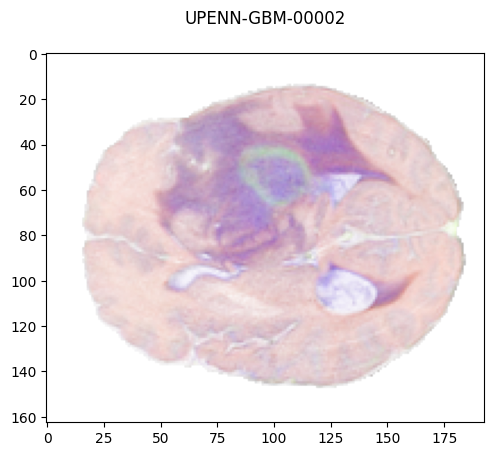

In [11]:
# display the first image
# plt.imshow(custom_ae_mri_data[0]['vol'].numpy().transpose((1, 2, 3, 0))[:, :, 73, :])
plt.imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, :])
with open(os.path.join(IMG_REDUCED_DIR, "data_list.txt"), 'r') as file:
    plt.title(file.readline());

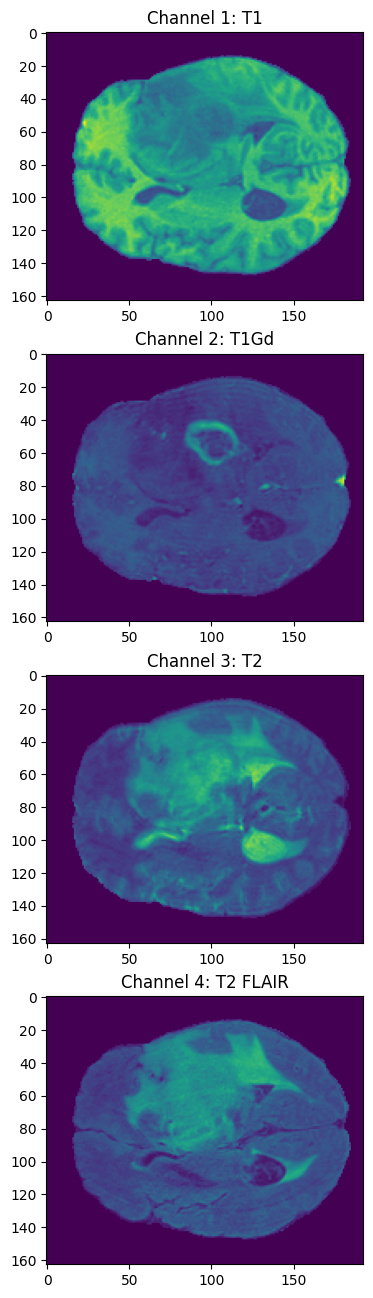

In [11]:
# show the four channels independently
fig, axs = plt.subplots(nrows=4, figsize=(6, 16))
axs[0].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 0], vmin=0, vmax=1)
axs[0].set_title('Channel 1: T1')
axs[1].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 1], vmin=0, vmax=1)
axs[1].set_title('Channel 2: T1Gd')
axs[2].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 2], vmin=0, vmax=1)
axs[2].set_title('Channel 3: T2')
axs[3].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 3], vmin=0, vmax=1)
axs[3].set_title('Channel 4: T2 FLAIR')
plt.show()

In [12]:
# set up data loader
batch_size = 1
dataloader = DataLoader(custom_ae_mri_data, batch_size=batch_size, shuffle=True)

### Train autoencoder

In [12]:
# Instantiate the model
model = Autoencoder(version='v3')

In [13]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (1): ReLU()
    (2): Conv3d(12, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (3): ReLU()
    (4): Conv3d(24, 72, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (5): ReLU()
    (6): Conv3d(72, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(3, 72, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): ConvTranspose3d(72, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(24, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (5): ReLU()
    (6): ConvTranspose3d(12, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)


In [14]:
# get model summary using torchsummary (similar to keras api summary for TF2)
# need to send model to device first or else there will be a mismatch in dtypes
# https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
if torch.cuda.is_available():
    summary(model.cuda(), input_size=(4, 163, 193, 146))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 12, 163, 193, 146]              60
              ReLU-2    [-1, 12, 163, 193, 146]               0
            Conv3d-3    [-1, 24, 163, 193, 146]             312
              ReLU-4    [-1, 24, 163, 193, 146]               0
            Conv3d-5    [-1, 72, 163, 193, 146]           1,800
              ReLU-6    [-1, 72, 163, 193, 146]               0
            Conv3d-7     [-1, 3, 163, 193, 146]             219
              ReLU-8     [-1, 3, 163, 193, 146]               0
   ConvTranspose3d-9    [-1, 72, 163, 193, 146]             288
             ReLU-10    [-1, 72, 163, 193, 146]               0
  ConvTranspose3d-11    [-1, 24, 163, 193, 146]           1,752
             ReLU-12    [-1, 24, 163, 193, 146]               0
  ConvTranspose3d-13    [-1, 12, 163, 193, 146]             300
             ReLU-14    [-1, 12, 163, 1

In [15]:
# specify the loss function
loss_fn = nn.MSELoss()

# create an optimizer
optimizer = torch.optim.Adam(model.parameters())  # use default lr=0.001

note: Using batch size of 32 and 5 training epochs takes ~7 minutes (420 seconds) for the baseline autoencoder $\leftarrow$ ~1.4 mins / epoch.

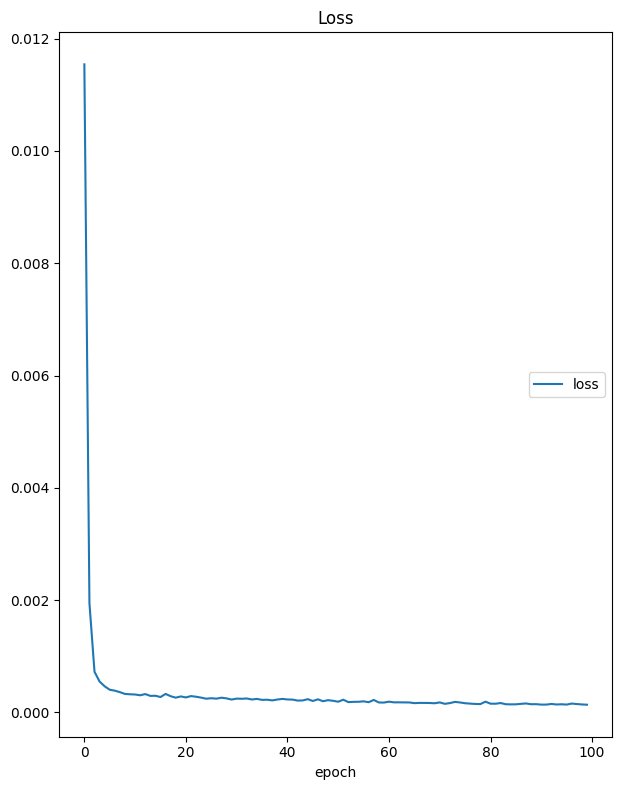

Loss
	loss             	 (min:    0.000, max:    0.012, cur:    0.000)


In [16]:
# call the training loop
autoencoder_training_loop(
    model,
    loss_fn,
    optimizer,
    dataloader,
    nepochs=100,
    early_stopping=True,
    patience=5,
    min_delta=1e-4,
    name='v3_model',
    chkpt_path=CHKPT_PATH,
    best_path=BEST_PATH
)

In [17]:
# download the last best model
final_best = sorted(os.listdir(BEST_PATH))[-1]
final_best_path = os.path.join(BEST_PATH, final_best)
final_best_zip_path = os.path.join(BEST_PATH, final_best + ".zip")
!zip $final_best_zip_path $final_best_path
files.download(final_best_zip_path)

# download the last checkpoint model
final_chkpt = sorted(os.listdir(CHKPT_PATH))[-1]
final_chkpt_path = os.path.join(CHKPT_PATH, final_chkpt)
final_chkpt_zip_path = os.path.join(CHKPT_PATH, final_chkpt + ".zip")
!zip $final_chkpt_zip_path $final_chkpt_path
files.download(final_chkpt_zip_path)

  adding: content/models/best/v3_model_current_best_epoch_91.pt (deflated 21%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/models/checkpoints/v3_model_checkpoint_epoch_90.pt (deflated 21%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2 hours

### Inference & analysis

At this point, typically it is best to restart the kernel, re-run all cells prior to training, and then start here for inference using the fitted model

In [13]:
# if re-load
if RELOAD_MODEL:
    # load saved model
    model = Autoencoder(version='v3')
    model.load_state_dict(torch.load("../fitted_models/autoencoder/v3_model_current_best_epoch_100.pt"))
    model.eval()  # set to evaluation for inference
    # send the model to GPU
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
else:
    # set the model to evaluation for inference
    model.eval()

In [14]:
# let's see what a reconstructed image looks like for the first input
reconstructed = model(custom_ae_mri_data[0]['vol'].to(torch.device("cuda"), dtype=torch.float))

In [15]:
print(f"input summary stats:\n min: {custom_ae_mri_data[0]['vol'].min()}\n max: {custom_ae_mri_data[0]['vol'].max()}\n mean: {custom_ae_mri_data[0]['vol'].mean()}")

input summary stats:
 min: 0.0
 max: 0.9999999997671694
 mean: 0.10280993230253377


In [16]:
print(f"reconstructed summary stats:\n min: {reconstructed.min()}\n max: {reconstructed.max()}\n mean: {reconstructed.mean()}")

reconstructed summary stats:
 min: -0.018527567386627197
 max: 1.064478874206543
 mean: 0.1014062911272049


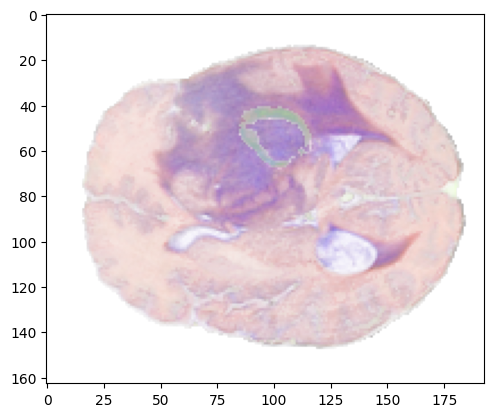

In [17]:
plt.imshow(reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)[:, :, 73, :]);

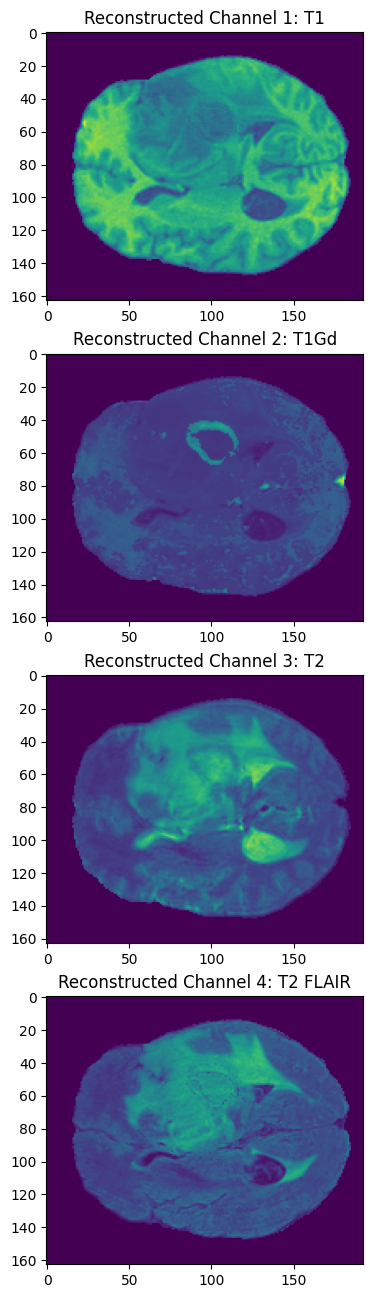

In [18]:
# show the four channels independently
reconstructed_np = reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)
fig, axs = plt.subplots(nrows=4, figsize=(6, 16))
axs[0].imshow(reconstructed_np[:, :, 73, 0], vmin=0, vmax=1)
axs[0].set_title('Reconstructed Channel 1: T1')
axs[1].imshow(reconstructed_np[:, :, 73, 1], vmin=0, vmax=1)
axs[1].set_title('Reconstructed Channel 2: T1Gd')
axs[2].imshow(reconstructed_np[:, :, 73, 2], vmin=0, vmax=1)
axs[2].set_title('Reconstructed Channel 3: T2')
axs[3].imshow(reconstructed_np[:, :, 73, 3], vmin=0, vmax=1)
axs[3].set_title('Reconstructed Channel 4: T2 FLAIR')
plt.show()

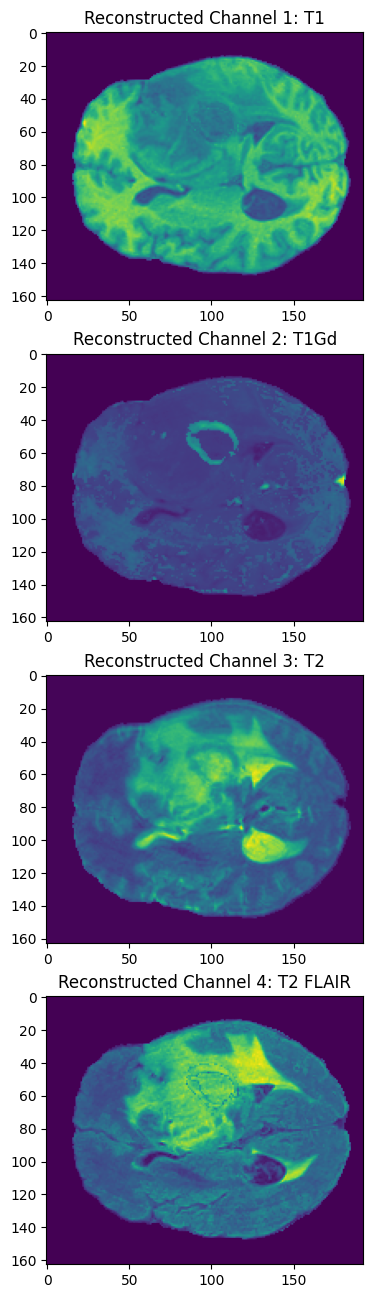

In [19]:
# show the four channels independently, but don't set color dynamic range
reconstructed_np = reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)
fig, axs = plt.subplots(nrows=4, figsize=(6, 16))
axs[0].imshow(reconstructed_np[:, :, 73, 0])
axs[0].set_title('Reconstructed Channel 1: T1')
axs[1].imshow(reconstructed_np[:, :, 73, 1])
axs[1].set_title('Reconstructed Channel 2: T1Gd')
axs[2].imshow(reconstructed_np[:, :, 73, 2])
axs[2].set_title('Reconstructed Channel 3: T2')
axs[3].imshow(reconstructed_np[:, :, 73, 3])
axs[3].set_title('Reconstructed Channel 4: T2 FLAIR')
plt.show()

In [20]:
# normalize the channels of the reconstructed data
normalized_reconstructed = normalize_channels(reconstructed)

In [21]:
print(f"reconstructed summary stats:\n min: {normalized_reconstructed.min()}\n max: {normalized_reconstructed.max()}\n mean: {normalized_reconstructed.mean()}")

reconstructed summary stats:
 min: 0.0
 max: 1.0
 mean: 0.10647330433130264


In [22]:
# what is the latent space representation?
latent_space_rep = model.encoder(custom_ae_mri_data[0]['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))

In [23]:
latent_space_rep.size()

torch.Size([3, 163, 193, 146])

In [24]:
print(f"Latent space summary stats:\n min: {latent_space_rep.min()}\n max: {latent_space_rep.max()}\n mean: {latent_space_rep.mean()}")

Latent space summary stats:
 min: 0.0
 max: 1.2022676467895508
 mean: 0.13967479765415192


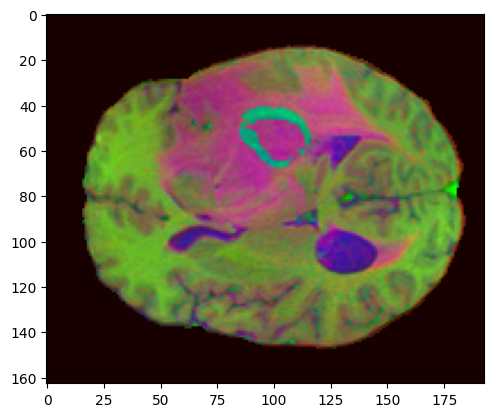

In [25]:
# visualize
plt.imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, :], vmin=0, vmax=1);

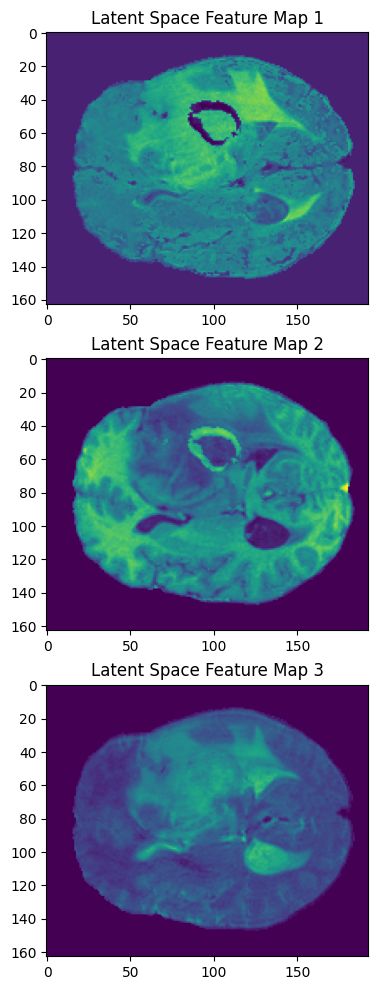

In [26]:
# show the three channels separately
fig, axs = plt.subplots(nrows=3, figsize=(6, 12))
axs[0].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 0], vmin=0, vmax=1)
axs[0].set_title('Latent Space Feature Map 1')
axs[1].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 1], vmin=0, vmax=1)
axs[1].set_title('Latent Space Feature Map 2')
axs[2].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 2], vmin=0, vmax=1)
axs[2].set_title('Latent Space Feature Map 3')
plt.show()

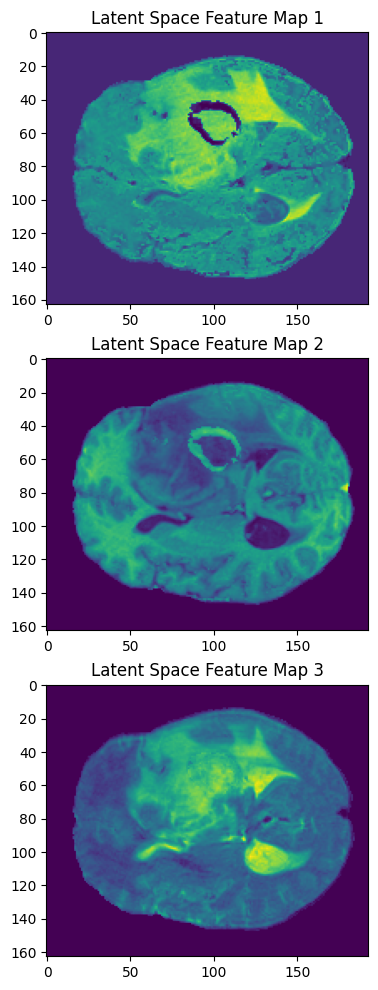

In [27]:
# show the three channels separately, but do not set color dynamic range
fig, axs = plt.subplots(nrows=3, figsize=(6, 12))
axs[0].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 0])
axs[0].set_title('Latent Space Feature Map 1')
axs[1].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 1])
axs[1].set_title('Latent Space Feature Map 2')
axs[2].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 2])
axs[2].set_title('Latent Space Feature Map 3')
plt.show()

## All volumes Inference

Pass all inputs through the encoder to get their latent space representation

In [28]:
!mkdir /content/data/latent_space_rep

In [29]:
OUTPUT_DIR = os.path.join(DATA_DIR, 'latent_space_rep')

model.encoder(custom_ae_mri_data[0]['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))

In [ ]:
for vol in custom_ae_mri_data:
    # generate latent space representation
    rep = model.encoder(vol['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))
    # detach and convert to numpy
    rep = rep.cpu().detach().numpy().transpose((1, 2, 3, 0))